### **Long Short Term Memory(LSTM)**,
a special type of Recurrent Neural Network(RNN) which can retain important information over time using memory cells.

This property of LSTMs makes it a wonderful algorithm to learn sequences that are interdependent and can help to build solutions like,
- language translation
- sales time series
- chatbots
- autocorrections
- next word suggestions, etc.

**Objective:** Using LSTM to learn the pattern in the stock prices, and predicting next days price of a stock based on the 10 days prices.

Library used: `yfinance`

Stock market ticker symbol: `NSEI` for infosys

In [1]:
# !pip install pandas numpy

In [2]:
!pip show pandas

Name: pandas
Version: 2.2.3
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: 
Author-email: The Pandas Development Team <pandas-dev@python.org>
License: BSD 3-Clause License
        
        Copyright (c) 2008-2011, AQR Capital Management, LLC, Lambda Foundry, Inc. and PyData Development Team
        All rights reserved.
        
        Copyright (c) 2011-2023, Open source contributors.
        
        Redistribution and use in source and binary forms, with or without
        modification, are permitted provided that the following conditions are met:
        
        * Redistributions of source code must retain the above copyright notice, this
          list of conditions and the following disclaimer.
        
        * Redistributions in binary form must reproduce the above copyright notice,
          this list of conditions and the following disclaimer in the documentation
          and/or other materials 

In [3]:
import pandas as pd
import numpy as np

# Remove scientific notations from numpy arrays
np.set_printoptions(suppress=True)

In [4]:
# installing nsepy library to get stock prices
!pip install yfinance

Defaulting to user installation because normal site-packages is not writeable


In [5]:
import yfinance as yf

# Define the date range
start_date = "2023-03-09"
end_date = "2025-03-13"

#### Main components

- **Ticker**: single ticker data
- **Tickers**: multiple tickers' data
- **download**: download market data for multiple tickers
- **Market**: get infomation about a market
- **Search**: quotes and news from search
- **Sector and Industry**: sector and industry information
- **EquityQuery and Screener**: build query to screen market

A stock symbol or a ticker is a unique series of letters assigned to a security for trading purposes. For example:

1. For Amazon, it is “AMZN”
2. For Meta, it is “META”
3. For Google, it is “GOOGL”

In [6]:
# Fetching NIFTY 50 data from Yahoo Finance
StockData = yf.download("^NSEI", start=start_date, end=end_date)

# Reset the index to move 'Date' from index to a column
StockData = StockData.reset_index()

# Print the shape of the data and show the first few rows
print(StockData.shape)
print(StockData.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

(495, 6)
Price        Date         Close          High           Low          Open  \
Ticker                    ^NSEI         ^NSEI         ^NSEI         ^NSEI   
0      2023-03-09  17589.599609  17772.349609  17573.599609  17772.050781   
1      2023-03-10  17412.900391  17451.500000  17324.349609  17443.800781   
2      2023-03-13  17154.300781  17529.900391  17113.449219  17421.900391   
3      2023-03-14  17043.300781  17224.650391  16987.099609  17160.550781   
4      2023-03-15  16972.150391  17211.349609  16938.900391  17166.449219   

Price   Volume  
Ticker   ^NSEI  
0       262400  
1       235900  
2       254900  
3       290600  
4       248200  


In [7]:
list(StockData.columns)

[('Date', ''),
 ('Close', '^NSEI'),
 ('High', '^NSEI'),
 ('Low', '^NSEI'),
 ('Open', '^NSEI'),
 ('Volume', '^NSEI')]

### Visualizing the stock prices movement

<Axes: xlabel='Date'>

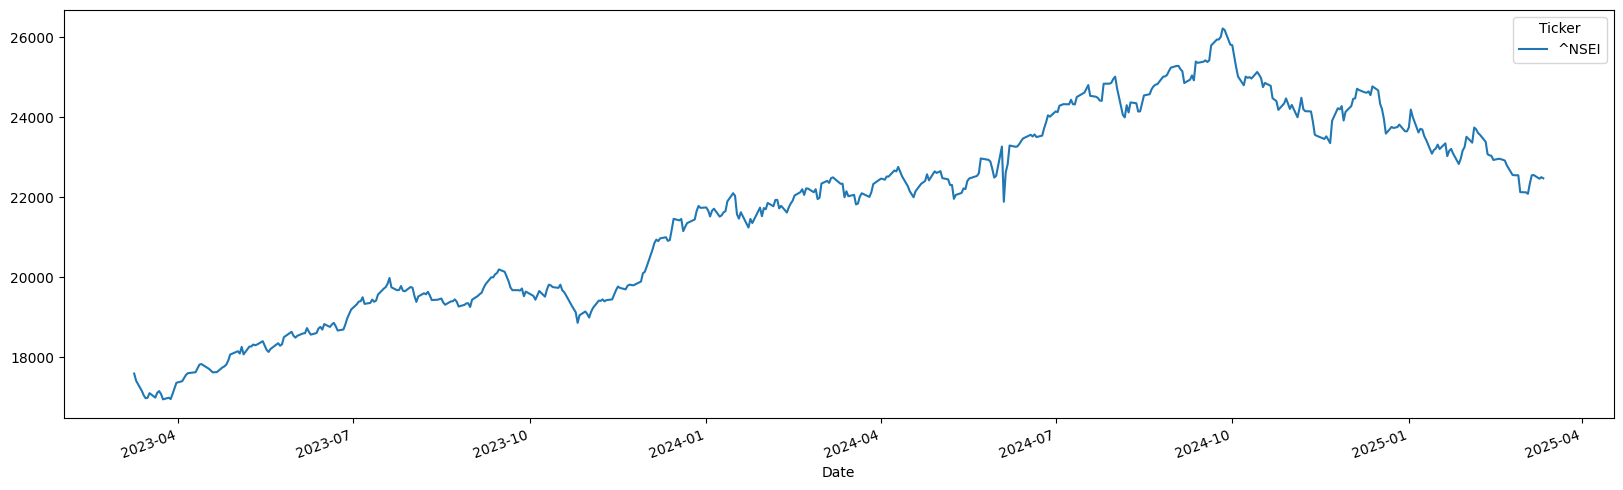

In [8]:
 # Plotting the stock prices
%matplotlib inline
StockData.plot(x='Date', y='Close', kind='line', figsize=(20,6), rot=20)

### Preparing the data

Giving data input into LSTM model in the form of X vs y, where,
- X : Represents the last 10 day's price
- y : Represents 11th day price

By looking at examples from last 2 years, LSTM would be able to learn the movement of price, thus after passing the last 10 days of price, it will be able to predict 11th days price.

Standardizing or normalizing the data is mandatory for a fast and more accurate fit as LSTM is a Neural network-based algorithm

In [9]:
# Extracting the closing prices of each day
FullData=StockData[['Close']].values
print(FullData[0:5])

[[17589.59960938]
 [17412.90039062]
 [17154.30078125]
 [17043.30078125]
 [16972.15039062]]


In [10]:
# Feature Scaling for fast training of the neural networks
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Choosing between Standardization or Normalization
# sc = StandardScaler()
sc=MinMaxScaler()

DataScaler=sc.fit(FullData)
X=DataScaler.transform(FullData)

print('### After Normalization ###')
X[0:5]

### After Normalization ###


array([[0.06952312],
       [0.05046377],
       [0.02257038],
       [0.01059756],
       [0.00292305]])

### Preparing the data for LSTM

In [11]:
# Split into samples
X_samples=list()
y_samples=list()

NumberOfRows=len(X)
# next day's Price Prediction is based on last 10 day's prices
TimeSteps=10

# Iterate through the values to create combinations
for i in range(TimeSteps, NumberOfRows, 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i]

    X_samples.append(x_sample)
    y_samples.append(y_sample)

In [12]:
print(f"TimeSteps: {TimeSteps} \nNumberOfRows: {NumberOfRows}")

TimeSteps: 10 
NumberOfRows: 495


In [13]:
# Reshape the Input as a 3D (number of sample, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0], X_data.shape[1], 1)
print('\nInput Data shape:')
print(X_data.shape)

# Reshape the input as a 3D data as it is supposed to be a single column only
y_data=np.array(y_samples)
y_data=y_data.reshape(y_data.shape[0], 1)
print('\nOutput data shape:')
print(y_data.shape)


Input Data shape:
(485, 10, 1)

Output data shape:
(485, 1)


### Splitting the data into training and testing

In [14]:
# Keeping few days data for testing records
TestingRecords=5

# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]

In [15]:
# Printing the shape of training and testing
print('\n #### Training Data Shape ####')
print(X_train.shape)
print(y_train.shape)
print('\n #### Testing Data Shape ####')
print(X_test.shape)
print(y_test.shape)



 #### Training Data Shape ####
(480, 10, 1)
(480, 1)

 #### Testing Data Shape ####
(5, 10, 1)
(5, 1)


### Visualizing the input and outpit data for LSTM

When input is 3D for the last 10 prices and output is 1D array of the next price.

In [16]:
for inp, out in zip(X_train[0:2], y_train[0:2]):
    print(inp, '-->', out)

[[0.06952312]
 [0.05046377]
 [0.02257038]
 [0.01059756]
 [0.00292305]
 [0.00437373]
 [0.0167188 ]
 [0.00467583]
 [0.0175223 ]
 [0.02231147]] --> [0.01422172]
[[0.05046377]
 [0.02257038]
 [0.01059756]
 [0.00292305]
 [0.00437373]
 [0.0167188 ]
 [0.00467583]
 [0.0175223 ]
 [0.02231147]
 [0.01422172]] --> [0.]


### Creating the DL LSTM model

- Using LSTM instead of Dense to define the hidden layers,
- The output has one neuron and we are predicting the next day price, for predicting for multiple days,
    - change input data and neurons equal to the number of days of forcast 

In [17]:
## Defining input shape for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps: ", TimeSteps)
print("NUmber of Features: ", TotalFeatures)

Number of TimeSteps:  10
NUmber of Features:  1


In [18]:
print(f"Shape of X_train: {X_train.shape}")

Shape of X_train: (480, 10, 1)


Using 3 inputs and 1 output layer, we can increase or decrease number of neurons in each hiddent layers.

Also can increase and decrease the number of the output layer sneurons  in the hiddsn layer.

Hyperparamers of LSTM model,

- **units=10**:
- **input_shape=(TimeSteps, TotalFeatures)**
- **kernel_initializer = uniform**
-  **kernel_initialziser = 'uniform'**
-  **activation='relu'**
- **neuron_sequence s= True**
- **optimizer='adam'**
- **batch_size=10**
- **epochs=10**




In [19]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [21]:
# Initializing the RNN
regressor=Sequential()

Adding the First input hidden layer and the LSTM layer and return_seqence = True,

- i.e. output of every time step to be shared with hidden next layer

In [22]:
regressor.add(LSTM(units=10, activation='relu', input_shape=(TimeSteps, TotalFeatures), return_sequences=True))

c:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Adding the Second hidden layer and the LSTM layer

In [23]:
regressor.add(LSTM(units=5, activation='relu', input_shape=(TimeSteps, TotalFeatures), return_sequences=True))

Adding the Third hidden layer and the LSTM layer

In [24]:
regressor.add(LSTM(units=5, activation='relu', return_sequences=True))

Adding the output layer

In [25]:
regressor.add(Dense(units=1))

Compiling the RNN

In [26]:
regressor.compile(optimizer='adam', loss='mean_squared_error')

Calculating the time for model to train

In [27]:
import time
# Measuing the tume taken by the model to train
StartTime=time.time()

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size=5, epochs=10)

EndTime=time.time()
print("## Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes ##')

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.2184
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0664
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0389
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0321
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0228
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0178
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0154
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0125
Epoch 9/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0103
Epoch 10/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0098
## Total Time Taken:  0 Minutes ##


#### Measuring the accuracy of the model on testing data

Using the trained model data,

- Making predictions on the test data

In [28]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_test: {y_test.shape}")


Shape of X_train: (480, 10, 1)
Shape of y_test: (5, 1)


In [29]:
predicted_Price=regressor.predict(X_test)

predicted_Price = predicted_Price.reshape(predicted_Price.shape[0], -1)

predicted_Price=DataScaler.inverse_transform(predicted_Price)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


In [30]:
df1=np.array(predicted_Price)
df1.size

50

In [31]:
# Getting the original price values for testing data
orig=y_test.reshape(y_test.shape[0],-1)
orig=DataScaler.inverse_transform(y_test)

# Accuracy of the predictions
print('Accuracy:', 100 - (100*(abs(orig-predicted_Price)/orig)).mean())


Accuracy: 98.5915921016509


Visualising the results

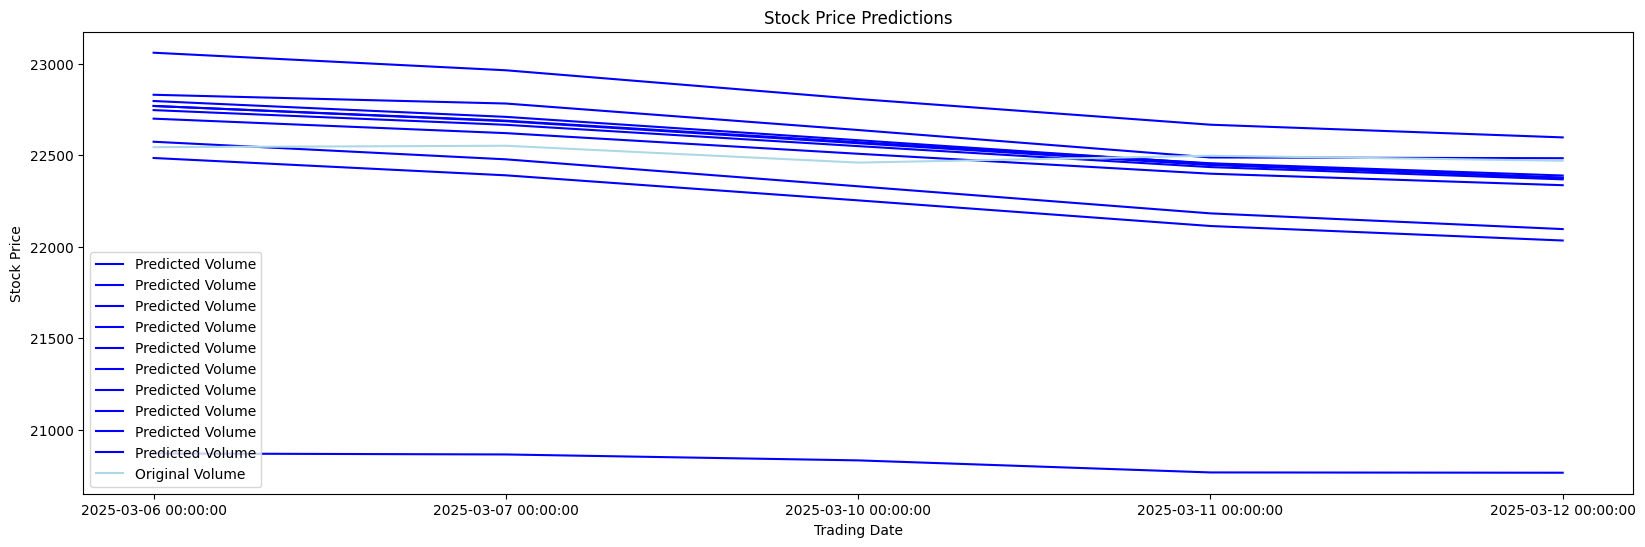

In [32]:
import matplotlib.pyplot as plt

plt.plot(predicted_Price, color = 'blue', label = 'Predicted Volume')
plt.plot(orig, color = 'lightblue', label = 'Original Volume')

plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.xticks(range(TestingRecords), StockData.tail(TestingRecords)['Date'])
plt.ylabel('Stock Price')

plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(6)
plt.show()

#### Visualizing the predictions for full data

In [33]:
# Generating predictions
TrainPredictions = regressor.predict(X_train).reshape(X_train.shape[0], -1)
TestPredictions = regressor.predict(X_test).reshape(X_test.shape[0], -1)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


In [34]:
# Apply inverse transformations
TrainPredictions=DataScaler.inverse_transform(TrainPredictions)
TestPredictions=DataScaler.inverse_transform(TestPredictions)

# Combining predictions for full data
FullDataPredictions = np.append(TrainPredictions, TestPredictions)

# Ensure FullData is properly sliced
FullDataOrig = FullData[TimeSteps:]

# Print the original data
print(FullDataOrig)

[[17076.90039062]
 [16945.05078125]
 [16985.69921875]
 [16951.69921875]
 [17080.69921875]
 [17359.75      ]
 [17398.05078125]
 [17557.05078125]
 [17599.15039062]
 [17624.05078125]
 [17722.30078125]
 [17812.40039062]
 [17828.        ]
 [17706.84960938]
 [17660.15039062]
 [17618.75      ]
 [17624.44921875]
 [17624.05078125]
 [17743.40039062]
 [17769.25      ]
 [17813.59960938]
 [17915.05078125]
 [18065.        ]
 [18147.65039062]
 [18089.84960938]
 [18255.80078125]
 [18069.        ]
 [18264.40039062]
 [18265.94921875]
 [18315.09960938]
 [18297.        ]
 [18314.80078125]
 [18398.84960938]
 [18286.5       ]
 [18181.75      ]
 [18129.94921875]
 [18203.40039062]
 [18314.40039062]
 [18348.        ]
 [18285.40039062]
 [18321.15039062]
 [18499.34960938]
 [18598.65039062]
 [18633.84960938]
 [18534.40039062]
 [18487.75      ]
 [18534.09960938]
 [18593.84960938]
 [18599.        ]
 [18726.40039062]
 [18634.55078125]
 [18563.40039062]
 [18601.5       ]
 [18716.15039062]
 [18755.90039062]
 [18688.09

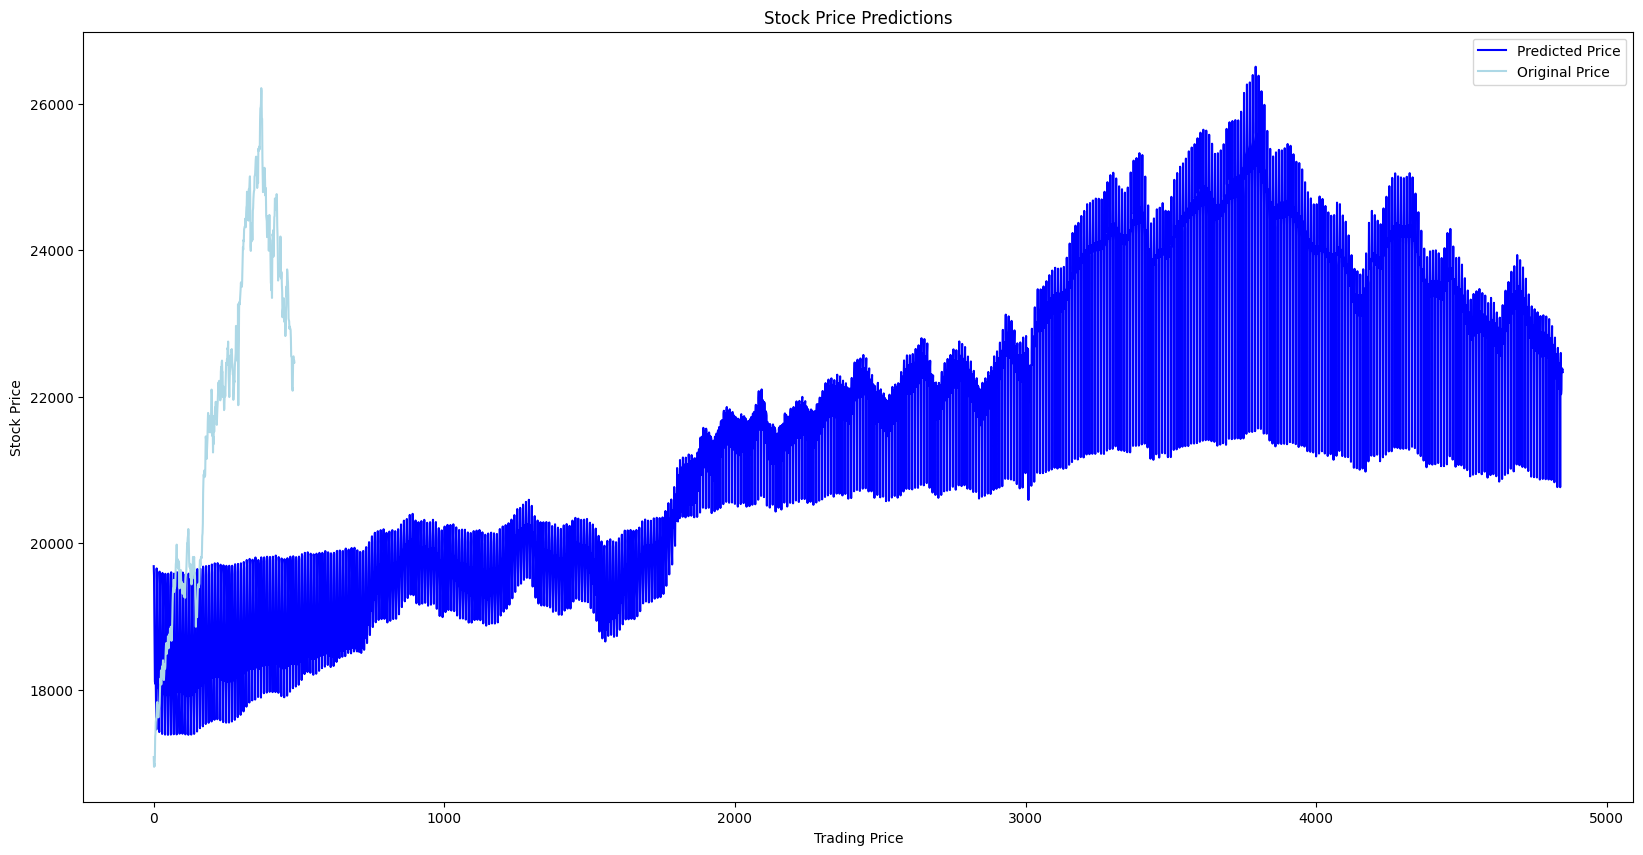

In [35]:
# Plotting the full data
plt.plot(FullDataPredictions, color='blue', label='Predicted Price')
plt.plot(FullDataOrig, color='lightblue', label='Original Price')

plt.title('Stock Price Predictions')
plt.xlabel('Trading Price')
plt.ylabel('Stock Price')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(10)
plt.show()

#### Predict the stock price for tomorrow
Passing the last 10 day's prices to the model in 3D format as it was used in training

In [36]:
# Closing prices of last 10 days from Stockdata
last_10_days = StockData['Close'].values[-10:]
last_10_days

array([[22545.05078125],
       [22124.69921875],
       [22119.30078125],
       [22082.65039062],
       [22337.30078125],
       [22544.69921875],
       [22552.5       ],
       [22460.30078125],
       [22497.90039062],
       [22470.5       ]])

In [37]:
# Normalizing the data
last_10_days=DataScaler.transform(last_10_days.reshape(-1,1))

In [38]:
# Changing the shape of the data to 3D
## Choosing timestamp as 10 because we have used the same for training
NumSamples=1
TimeSteps=10
NumFeatures=1
last_10_days=last_10_days.reshape(NumSamples, TimeSteps, NumFeatures)
last_10_days.shape

(1, 10, 1)

Making predictions on the data

In [39]:
predicted_Price=regressor.predict(last_10_days)

# Reshape from 3D to 2D (MinMaxScaler expects 2D)
predicted_Price = predicted_Price.reshape(-1, 1)  

# Inverse transform to get actual stock price
predicted_Price = DataScaler.inverse_transform(predicted_Price)

print(f"Predicted Stock Price for Tomorrow: {predicted_Price[0][0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Predicted Stock Price for Tomorrow: 20763.25


In [40]:
actual_price = float(StockData['Close'].iloc[-1])  # Convert to float explicitly

# Calculate the absolute difference
difference = abs(actual_price - predicted_Price[0][0])

# Calculate the percentage difference
percentage_difference = (difference / actual_price) * 100

# Display results
print(f"Predicted Price for Tomorrow: {predicted_Price[0][0]:.2f}")
print(f"Actual Closing Price: {actual_price:.2f}")  # Now works without error
print(f"Absolute Difference: {difference:.2f}")
print(f"Percentage Difference: {percentage_difference:.2f}%")

Predicted Price for Tomorrow: 20763.25
Actual Closing Price: 22470.50
Absolute Difference: 1707.25
Percentage Difference: 7.60%


C:\Users\Hp\AppData\Local\Temp\ipykernel_9400\3755999991.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  actual_price = float(StockData['Close'].iloc[-1])  # Convert to float explicitly


In [41]:
# Get the latest available date in StockData
actual_date = StockData['Date'].iloc[-1]

# Assuming tomorrow’s date for the prediction (next trading day)
import pandas as pd
tomorrow_date = pd.to_datetime(actual_date) + pd.DateOffset(1)

# Both dates are in the same format, so we can directly compare them
print(f"Actual Closing Price Date: {actual_date}")
print(f"Predicted Price Date: {tomorrow_date.date()}")

if actual_date == tomorrow_date:
    print("Both are referring to the same date!")
else:
    print("Prediction is for tomorrow, while actual price is from today.")

Actual Closing Price Date: 2025-03-12 00:00:00
Predicted Price Date: 2025-03-13
Prediction is for tomorrow, while actual price is from today.


In [42]:
import yfinance as yf

# Fetch updated stock data
start_date = "2023-03-09"
end_date = "2025-03-15"  # Extend to today to get recent data
StockData = yf.download("^NSEI", start=start_date, end=end_date)

# Reset index to access the 'Date' column easily
StockData = StockData.reset_index()

# Extract actual closing price for March 13, 2025
actual_price = StockData.loc[StockData['Date'] == '2025-03-13', 'Close'].values

if actual_price.size > 0:
    actual_price = float(actual_price[0])

    # Calculate the absolute difference
    difference = abs(actual_price - predicted_Price[0][0])

    # Calculate the percentage difference
    percentage_difference = (difference / actual_price) * 100

    # Display results
    print(f"Predicted Price for March 13, 2025: {predicted_Price[0][0]:.2f}")
    print(f"Actual Closing Price for March 13, 2025: {actual_price:.2f}")
    print(f"Absolute Difference: {difference:.2f}")
    print(f"Percentage Difference: {percentage_difference:.2f}%")

else:
    print("Actual price for March 13, 2025, not found in dataset.")


[*********************100%***********************]  1 of 1 completed

Predicted Price for March 13, 2025: 20763.25
Actual Closing Price for March 13, 2025: 22397.20
Absolute Difference: 1633.95
Percentage Difference: 7.30%



C:\Users\Hp\AppData\Local\Temp\ipykernel_9400\3618907181.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_price = float(actual_price[0])


### Multi-Step time series prediction: Predicting multiple time steps ahead

Can we use it to predict prices for the next 5 days?

- Earlier used for 10 days, i.e. last 10 days prices–> 11th day price

- Can be used to predict the next 5 days or next 20 days prices,
    - last 10 days prices–> Next 5 days prices

##### Data Preparation for Multi-Step LSTM

In [43]:
# Predicting the last 10 values
print('Original Prices: ')
print(FullData[-10:])

print('\n')
 
# Printing last 10 values of the scaled data which created above for the last model
# Changing the shape of the data to one dimensional array because for Multi step data preparation we need to X input in this fashion
X=X.reshape(X.shape[0],)
print('Scaled Prices: ')
print(X[-10:])

Original Prices: 
[[22545.05078125]
 [22124.69921875]
 [22119.30078125]
 [22082.65039062]
 [22337.30078125]
 [22544.69921875]
 [22552.5       ]
 [22460.30078125]
 [22497.90039062]
 [22470.5       ]]


Scaled Prices: 
[0.60403408 0.55869361 0.55811131 0.55415809 0.5816255  0.60399616
 0.60483758 0.59489268 0.59894829 0.5959928 ]


In [44]:
FutureTimeSteps=10

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

# Initializing the RNN
regressor=Sequential()

In [46]:
## Adding the first hidden layer and the LSTM layer
#return_sequences = True, meaning the output of every step to be shared with the next layer
regressor.add(LSTM(units=10, activation='relu', input_shape=(TimeSteps, TotalFeatures), return_sequences=True))

## Adding the second hidden layer and the LSTM layer
regressor.add(LSTM(units=10, activation='relu', input_shape=(TimeSteps, TotalFeatures), return_sequences=True))

## Adding the third hidden layer and the LSTM layer
regressor.add(LSTM(units=5, activation='relu', return_sequences=False))

#### Adding the output layer
regressor.add(Dense(units=FutureTimeSteps))

## Compiling the RNN
regressor.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [47]:
import time

# Measuring the time taken by the model to train
start_time = time.time()

# Fitting the RNN to the training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)
 
EndTime=time.time()
print("############### Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes #############')

Epoch 1/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.2691
Epoch 2/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0373
Epoch 3/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0084
Epoch 4/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0057
Epoch 5/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0044
Epoch 6/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0039
Epoch 7/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0032
Epoch 8/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0030
Epoch 9/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0030
Epoch 10/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0027
Epoch 11/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0023
Epoch 12/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0022
Epoch 13/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0023
Epoch 14/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0020
Epoch 15/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0023
E

#### Measuring the accuracy of the model on testing data

- As it's multi-step model trained to predict for next **FutureTimeSteps** days, each prediction will generate a sequence of **FutureTimeSteps** predictions. 

- We will calculate the accuracy of the model on to the original prices

Each row represents the original prices and the predicted prices.

- We will now compare one row at a time, and calculate the difference between the original price and the predicted price.

In [48]:
from sklearn.preprocessing import StandardScaler

close_data = StockData['Close'].values.reshape(-1,1)

DataScaler = StandardScaler()
scaled_close = DataScaler.fit_transform(close_data)

data = scaled_close

In [49]:
TimeSteps = 60
FutureTimeSteps = 10

X_data, y_data = [], []

for i in range(len(data) - TimeSteps - FutureTimeSteps + 1):
    X_data.append(data[i : i + TimeSteps])
    y_data.append(data[i + TimeSteps : i + TimeSteps + FutureTimeSteps])

In [50]:
TestingRecords = FutureTimeSteps  # = 10
X_train = X_data[:-TestingRecords]
X_test = X_data[-TestingRecords:]
y_train = y_data[:-TestingRecords]
y_test = y_data[-TestingRecords:]

In [51]:
predicted_Price = DataScaler.inverse_transform(predicted_Price)
y_test = np.array(y_test)
orig = DataScaler.inverse_transform(y_test.reshape(-1, FutureTimeSteps))

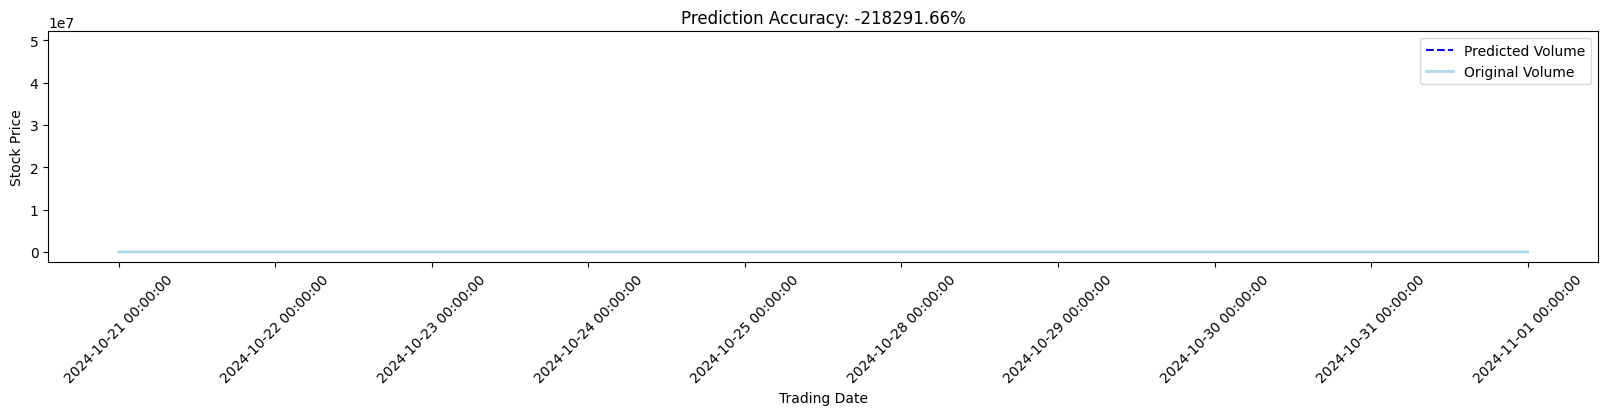

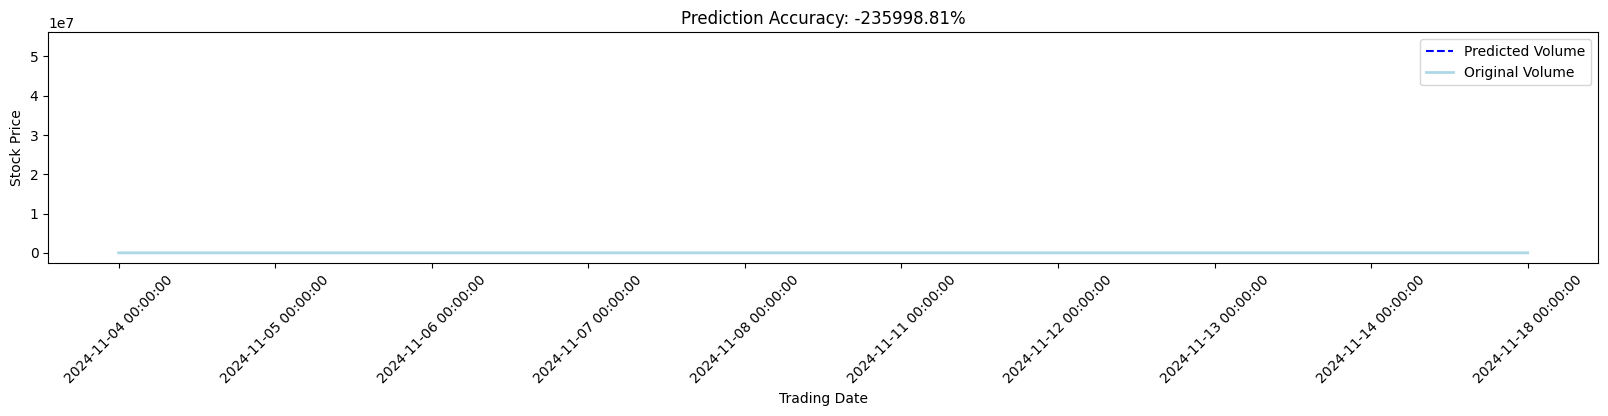

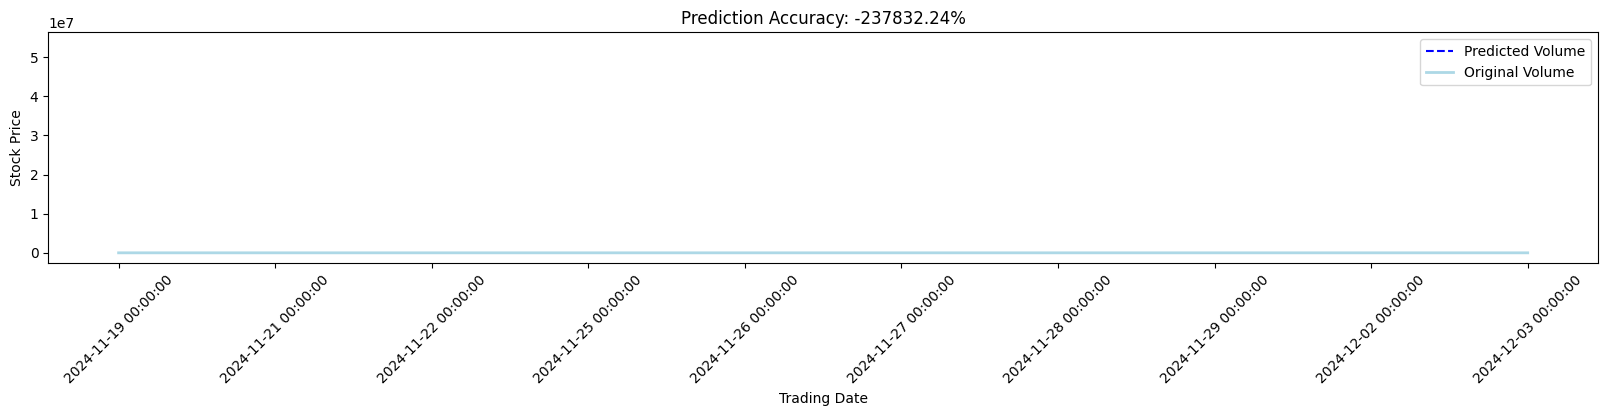

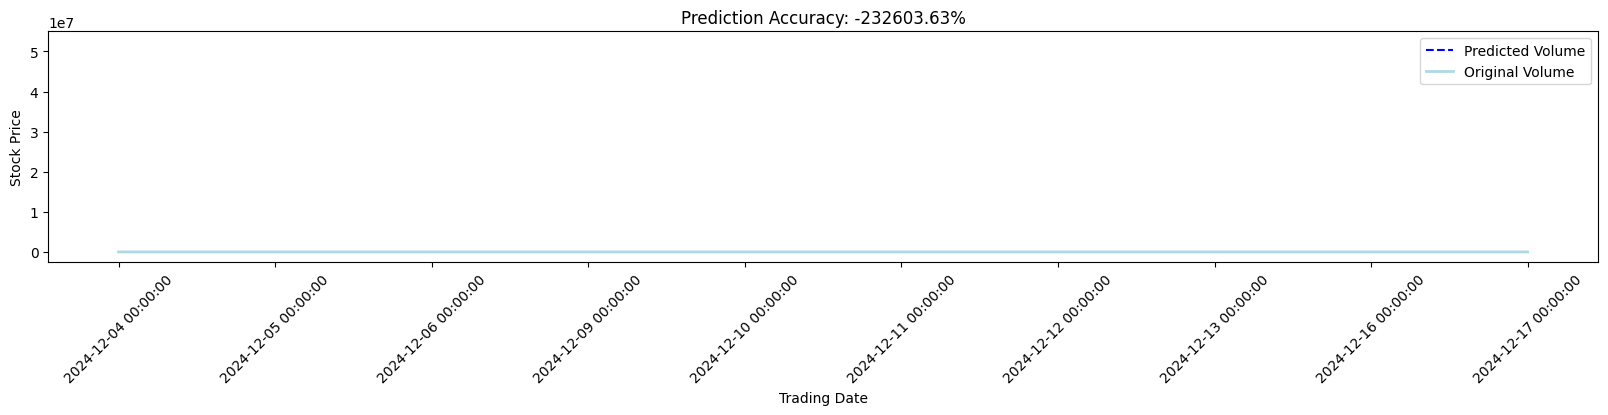

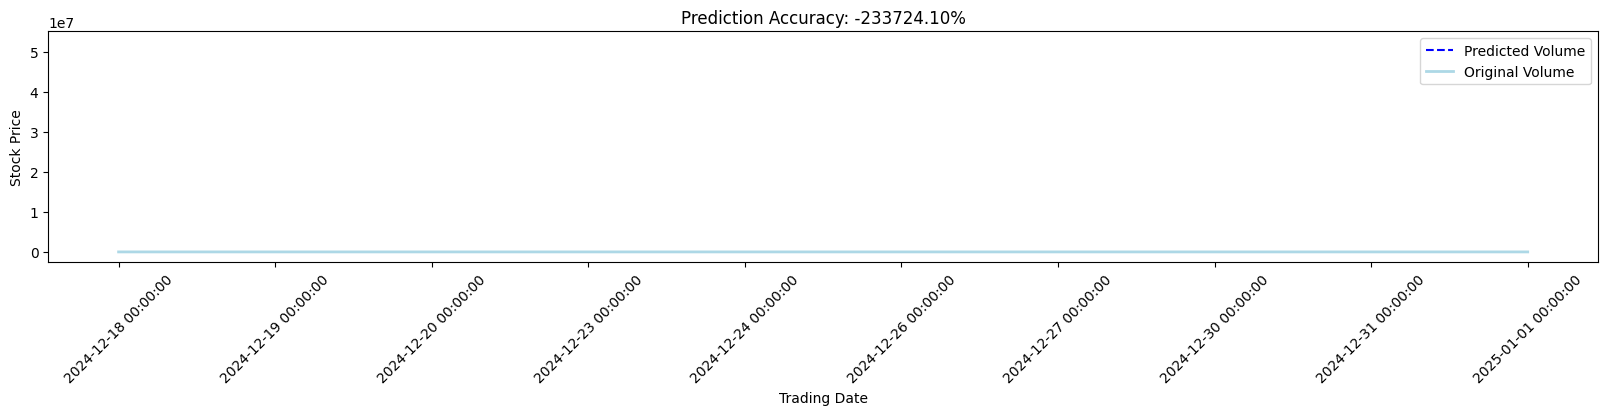

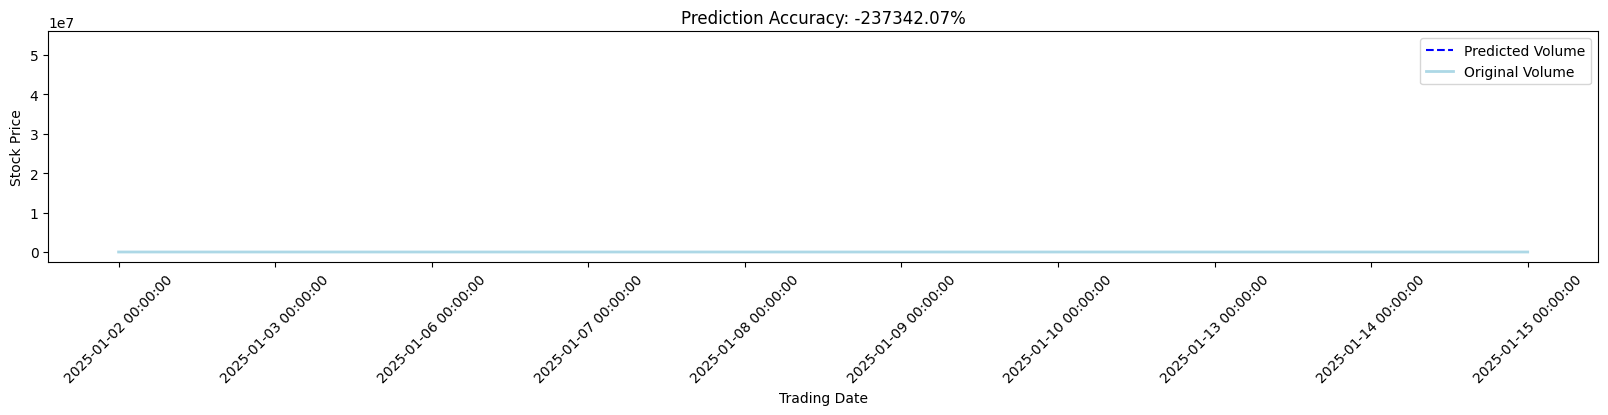

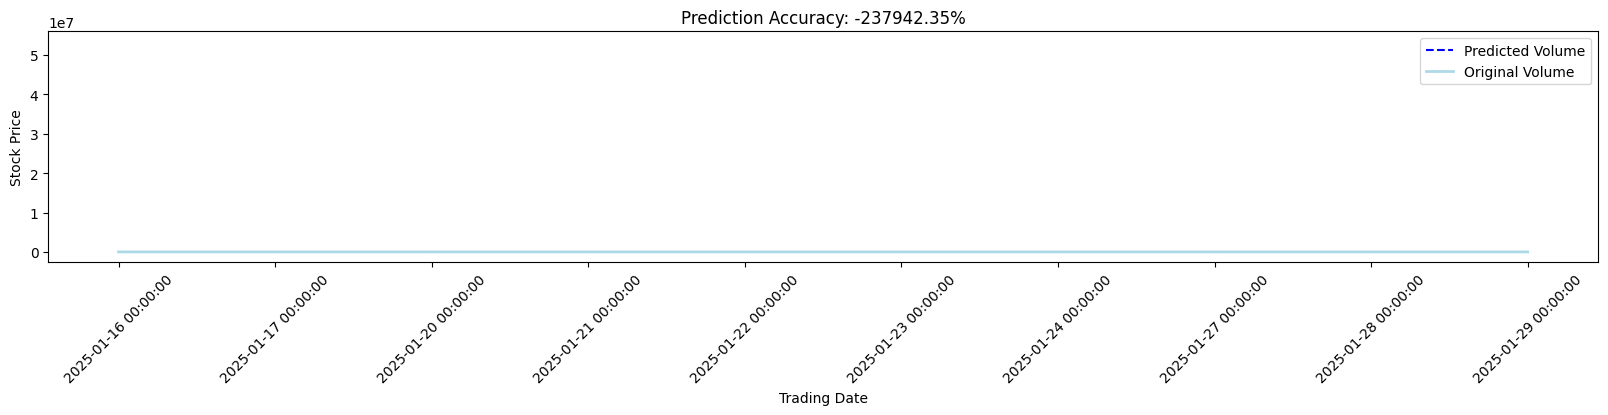

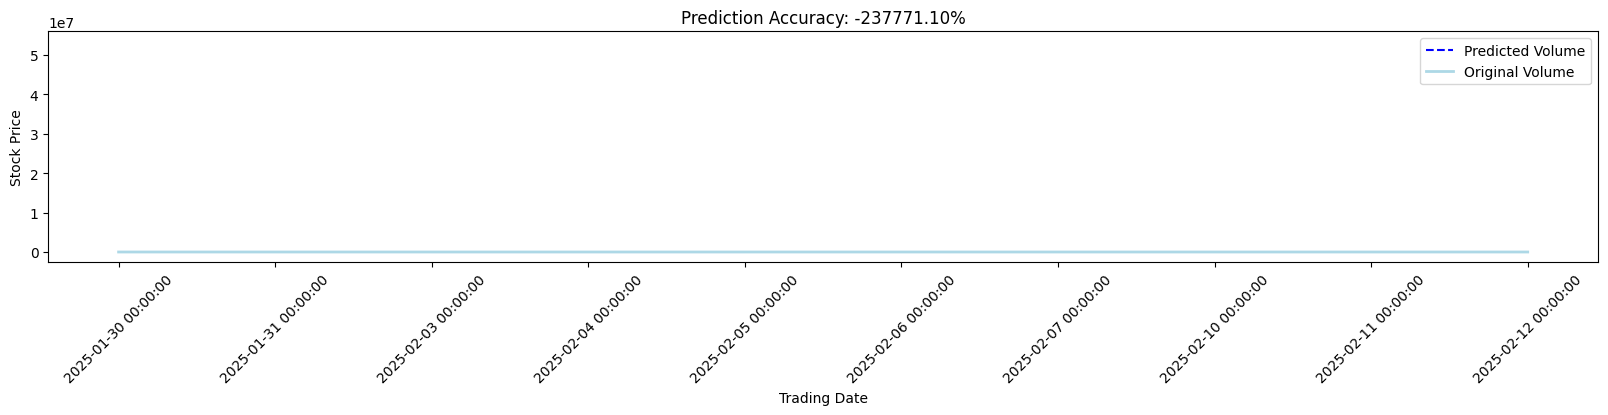

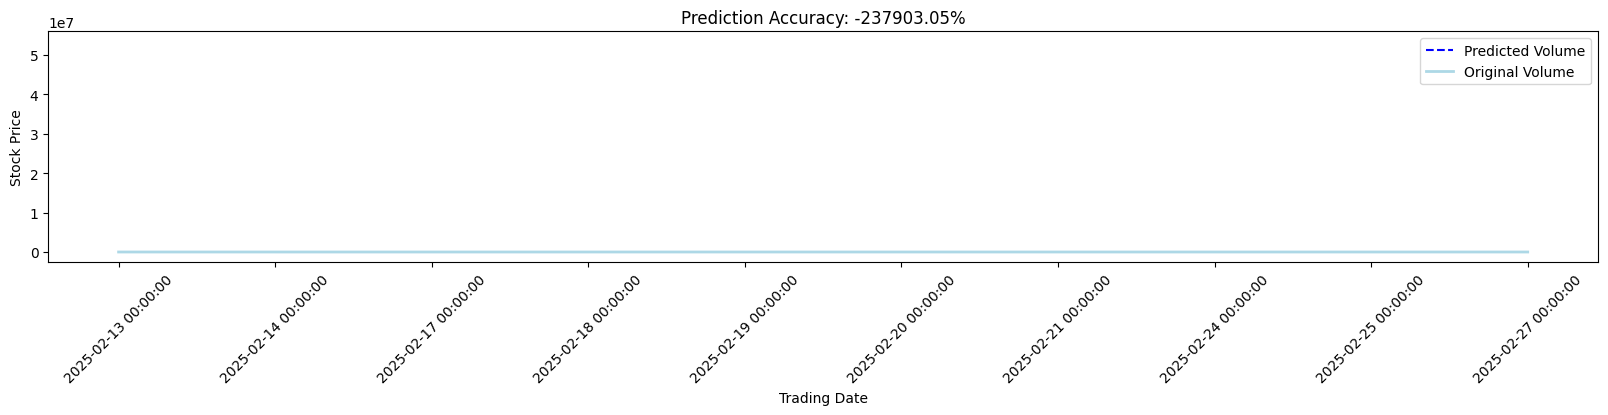

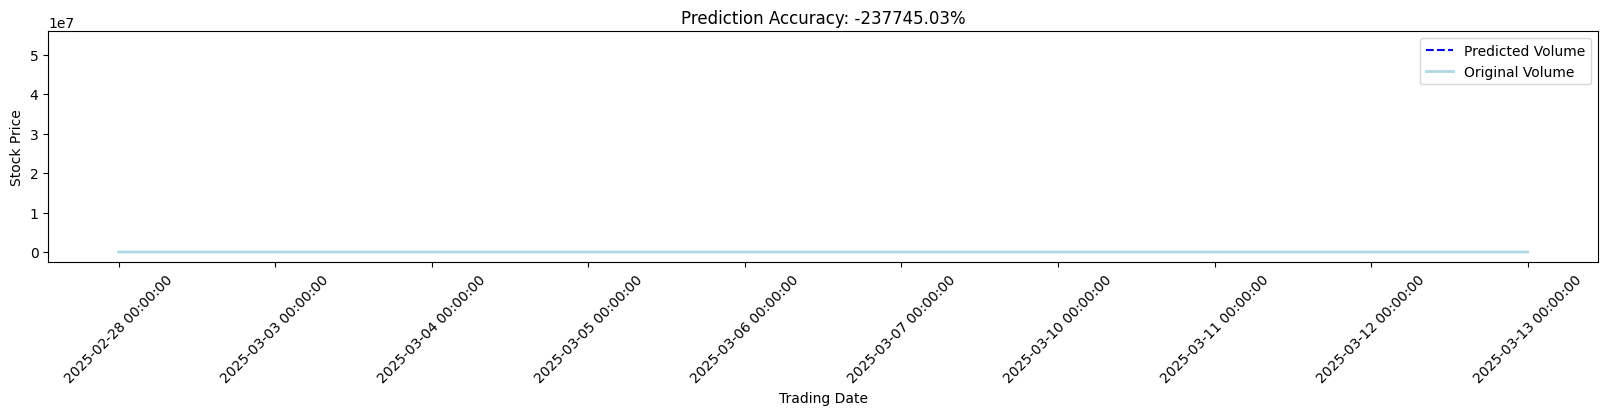

In [52]:
import matplotlib.pyplot as plt

for i in range(len(predicted_Price)):
    Prediction=predicted_Price[i]
    Original=orig[i]

    # Visualizing the results
    plt.plot(Prediction, color='blue', label='Predicted Volume', linestyle='--')
    plt.plot(Original, color='lightblue', label='Original Volume', linewidth=2)

    accuracy = 100 - (100 * abs(Original - Prediction) / Original).mean()
    plt.title(f'Prediction Accuracy: {accuracy:.2f}%')
    plt.xlabel('Trading Date')

    # Setting the X-axis dates correctly
    startDataIndex = (FutureTimeSteps * TestingRecords) - FutureTimeSteps * (i + 1)
    endDataIndex = startDataIndex + FutureTimeSteps
    TotalRows = StockData.shape[0]

    date_range = StockData.iloc[TotalRows - endDataIndex : TotalRows - startDataIndex]['Date']
    plt.xticks(range(FutureTimeSteps), date_range, rotation=45)

    plt.ylabel('Stock Price')
    plt.legend()
    fig = plt.gcf()
    fig.set_figwidth(20)
    fig.set_figheight(3)
    plt.show()

# Incomplete